In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.lib.histograms import histogram
import seaborn as sns

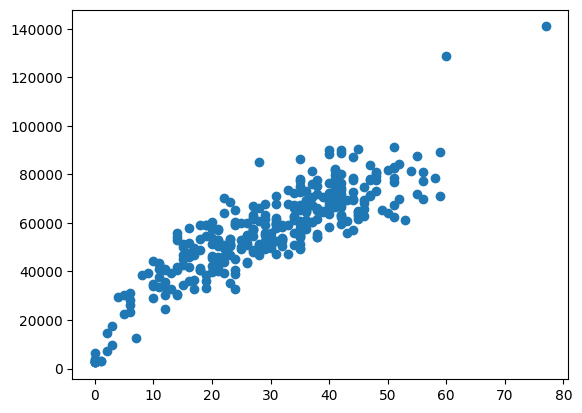

In [27]:
silver = pd.read_csv("silver_data")

plt.scatter(silver['totalKills'], silver['totalGold'])

plt.show()

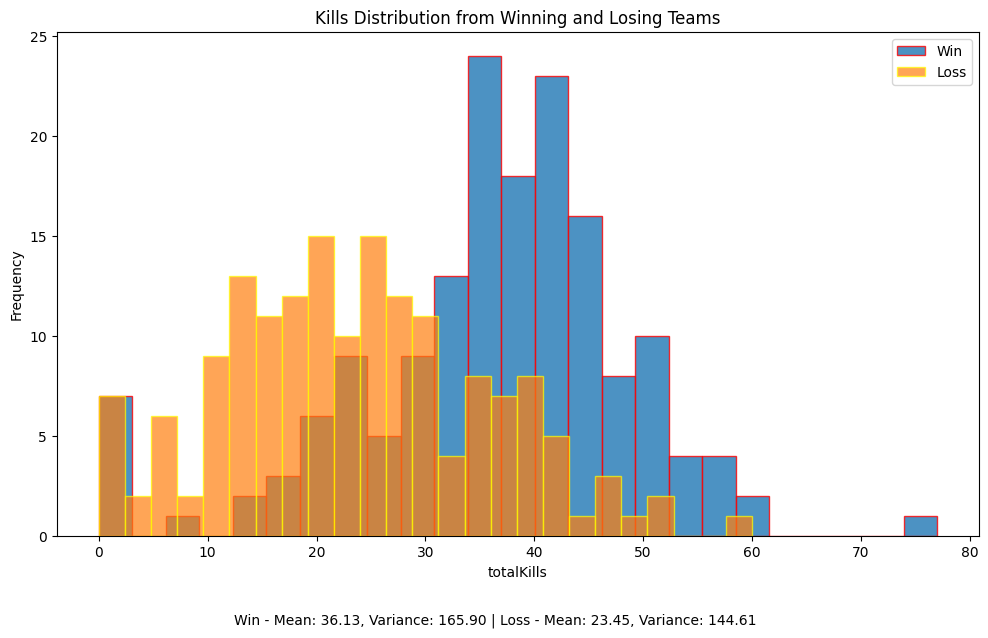

In [28]:
import matplotlib.pyplot as plt

# Calculate summary statistics
win_kills = silver[silver['win'] == True]['totalKills']
loss_kills = silver[silver['win'] == False]['totalKills']

win_mean = win_kills.mean()
win_var = win_kills.var()

loss_mean = loss_kills.mean()
loss_var = loss_kills.var()

# Create the plot
plt.figure(figsize=(10, 6))
plt.hist(win_kills, label="Win", bins=25, alpha=0.8, edgecolor='red')
plt.hist(loss_kills, label="Loss", bins=25, alpha=0.7, edgecolor='yellow')

# Labels and title
plt.xlabel('totalKills')
plt.ylabel('Frequency')
plt.title('Kills Distribution from Winning and Losing Teams')
plt.legend()

# Add summary statistics below the plot
plt.figtext(0.5, -0.05, 
            f"Win - Mean: {win_mean:.2f}, Variance: {win_var:.2f} | "
            f"Loss - Mean: {loss_mean:.2f}, Variance: {loss_var:.2f}",
            wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()
plt.show()


<Axes: >

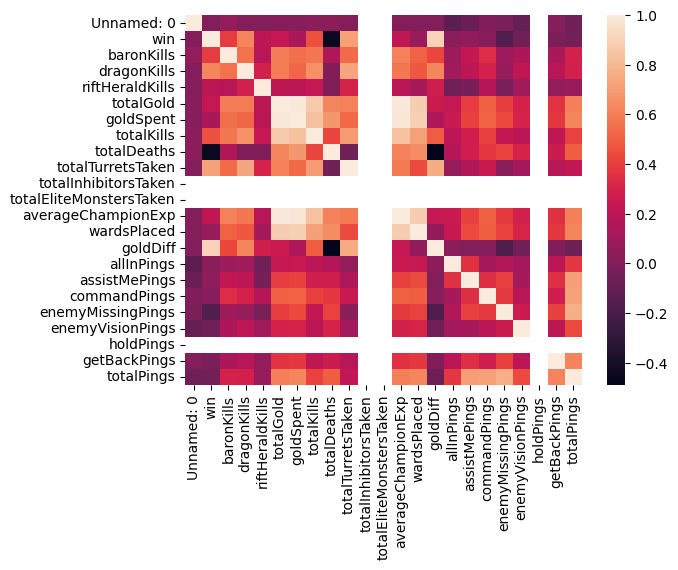

In [29]:
silver_heat = silver.drop(columns=['matchId', 'teamId'])
sns.heatmap(silver_heat.corr())


In [31]:
silver_heat['totalInhibitorsTaken']

0      0
1      0
2      0
3      0
4      0
      ..
325    0
326    0
327    0
328    0
329    0
Name: totalInhibitorsTaken, Length: 330, dtype: int64